In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
#fit VAR 
x = pd.read_csv('/Users/andrewslottje/Documents/x.csv', parse_dates=True)
x = x.rename(columns={"[TimeStamp]":"Timestamp"})
x['Set']="Train"
CV_x = pd.read_csv('/Users/andrewslottje/Documents/cv_x.csv', parse_dates=True).rename(columns={"[TimeStamp]":"Timestamp"})
CV_x['Set']="CV"
test_x = pd.read_csv('/Users/andrewslottje/Documents/test_x.csv', parse_dates=True).rename(columns={"[TimeStamp]":"Timestamp"})
test_x['Set']="Test"
x = x.append(CV_x).append(test_x)

In [ ]:
endog = x[['ETHreturn','XRPreturn','LTCreturn','DASHreturn','XMRreturn']]
exog = x[['ETHspread','ETHvolume','ETHbasevolume','XRPspread',
          'XRPvolume','XRPbasevolume','LTCspread','LTCvolume',
          'LTCbasevolume','DASHspread','DASHvolume','DASHbasevolume','XMRspread','XMRvolume','XMRbasevolume']].shift(-1)
x.index = pd.DatetimeIndex(x.Timestamp)
endog.index = pd.DatetimeIndex(x.Timestamp)
exog.index = pd.DatetimeIndex(x.Timestamp)
x = x[:-1]
endog = endog[:-1]
exog = exog[:-1]

In [ ]:
mod = sm.tsa.VARMAX(endog[['ETHreturn','XRPreturn','LTCreturn','DASHreturn','XMRreturn']], order=(0,3), exog=exog)
res = mod.fit(maxiter=20, disp=False)
for i in ['ETH','XRP','LTC','DASH','XMR']:
    x[str(i)+'predict']=res.fittedvalues[str(i)+'return']
    x[str(i)+'return_resid']=(x[str(i)+'return']-res.fittedvalues[str(i)+'return'])
    #x[str(i)+'return_resid_chg']=np.log(x[str(i)+'return_resid']/x[str(i)+'return_resid'].shift(1))

In [2]:
#create output variables
x = pd.read_csv('/Users/andrewslottje/Downloads/var_train_out_new.csv', parse_dates=True).drop('Timestamp.1',axis=1)
#generate lagged data
for i in x.columns.values:
#for i in ['ETHreturn','ETHspread_d','ETHvolume_d','XRPreturn','LTCreturn','DASHreturn','XMRreturn']:
    #generate 3 lags of data
    for j in range(1,4):
        x[str(i)+"_l"+str(j)]=x[str(i)].shift(j)

for i in ['ETH','XRP','LTC','DASH','XMR']:
    x[str(i)+'returnindicator']=0.0
    x.loc[x[str(i)+'return']>.005,str(i)+'returnindicator']=1.0
    x[str(i)+'returnindicator']=x[str(i)+'returnindicator'].shift(-1)
#drop nan rows
x=x.drop(x.index[0:4]).drop(['Set_l1','Set_l2','Set_l3'],axis=1)
#x=x.drop(x.index[-1:])
x.to_csv('/Users/andrewslottje/Documents/varmax_out_new.csv')

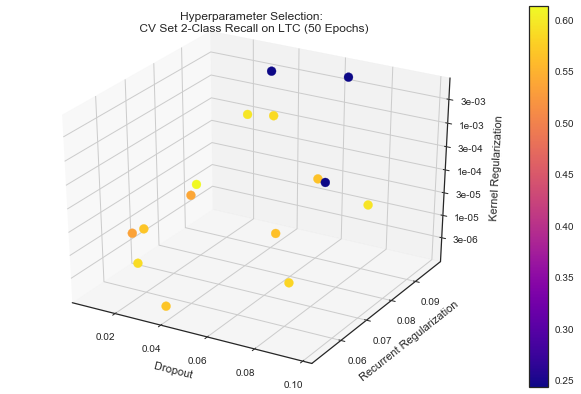

In [19]:
#plot hyperparameter tuning
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
#3D log scale from https://github.com/matplotlib/matplotlib/issues/209#issuecomment-138667884
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
jet=plt.get_cmap('plasma')
xs = [0.0857111, 0.06493153, 0.09719547, 0.03452272, 0.04365971,0.07858348, 0.04533994, 0.02109507, 0.07980589, 0.00748439, 0.0384001,
 0.0310935, 0.02502601, 0.013353, 0.08886369][0:15]
ys = [0.0668385, 0.09744395, 0.05896688, 0.09505269, 0.08783976,0.05787044, 0.05818616, 0.07595222, 0.06181159, 0.06959856, 0.05230097,
 0.08889851, 0.05355476, 0.0609963, 0.08373552][0:15]
zs = [0.00078214, 0.00491114, 0.00176729, 0.00398557, 0.00099106,1.07607119e-04, 4.58656795e-04, 2.98705963e-05, 6.79751184e-06,
 6.70951698e-06, 1.63254352e-06, 7.20763165e-04, 8.60962753e-06, 1.39912127e-05, 5.33687265e-05][0:15]
c = [0.5635665529010239, 0.2431740614334471,0.2431740614334471,.2431740614334471,.58660409556314,.5631399317406144,.6126279863481229,.53839590443686,
    .5819112627986348,.5674061433447098,.5669795221843004,0.5959897610921502,0.587457337883959,
    0.5332764505119454,0.5951365187713311]
p = ax.scatter(xs, ys, np.log10(zs), c=c, cmap=jet,s=80,alpha=1)

ax.set_xlabel('\n Dropout')
ax.set_ylabel('\n Recurrent Regularization')
ax.set_zlabel('\n \n Kernel Regularization')

def log_tick_formatter(val, pos=None):
    return "{:.0e}".format(10**val)

ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))

fig.colorbar(p)
plt.title('Hyperparameter Selection: \n CV Set 2-Class Recall on LTC (50 Epochs)')
plt.show()

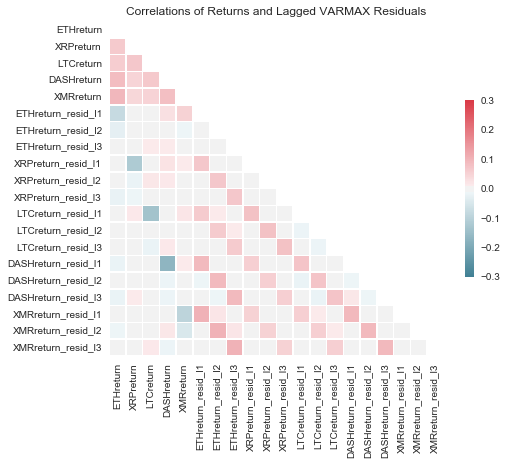

In [16]:
#plot correlations
corrvars = x[['ETHreturn','XRPreturn','LTCreturn','DASHreturn','XMRreturn','ETHreturn_resid_l1','ETHreturn_resid_l2','ETHreturn_resid_l3',
  'XRPreturn_resid_l1','XRPreturn_resid_l2','XRPreturn_resid_l3','LTCreturn_resid_l1',
  'LTCreturn_resid_l2','LTCreturn_resid_l3','DASHreturn_resid_l1','DASHreturn_resid_l2',
  'DASHreturn_resid_l3','XMRreturn_resid_l1','XMRreturn_resid_l2','XMRreturn_resid_l3']]

#https://seaborn.pydata.org/examples/many_pairwise_correlations.html
import seaborn as sns
sns.set(style="white")
corr = corrvars.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7.5, 6.5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations of Returns and Lagged VARMAX Residuals')
plt.show()

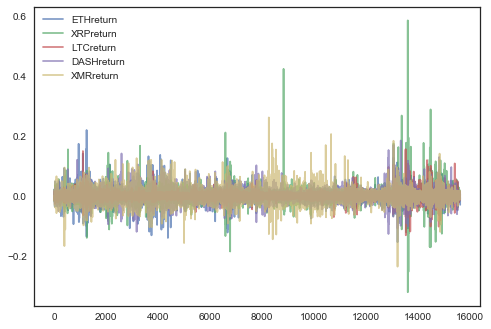

In [25]:
#plot volatility
plt.plot(x[['ETHreturn','XRPreturn','LTCreturn','DASHreturn','XMRreturn']],alpha=.7)
plt.legend(['ETHreturn','XRPreturn','LTCreturn','DASHreturn','XMRreturn'])
plt.show()

In [29]:
#volatilities
for i in ['ETHreturn','XRPreturn','LTCreturn','DASHreturn','XMRreturn']:
    print(np.sqrt(np.var(x[str(i)])))

0.0167992499423
0.0187274852113
0.0111201600392
0.0165823705446
0.0194142887971
